* This notebook shows perfomance comparisons of four NLP sentiment models on two different sources of sentiment Apple stock. Correlations between closing price and each sentiment model has been measured with a regression score (coefficient of dermination) and mean squared error. The specific regressors and their respecitve hyperparameters have been determined through a genetic search algorithm using the TPOT regressor.

* Sources of sentiment: (1) twitter, (2) reddit.

* NLP models: vader, vader with lexicon, textblob, all of them combined.

### Requirements

In [1]:
!pip install tweet-preprocessor tpot

     |████████████████████████████████| 81kB 5.3MB/s 
     |████████████████████████████████| 942kB 15.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/1b/27/cc/49938e98a2470802ebdefae9d2b3f524768e970c1ebbe2dc4a
  Stored in directory: /root/.cache/pip/wheels/22/ea/bf/dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built tweet-preprocessor deap stopit


In [2]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from datetime import datetime
import datetime
import preprocessor as p
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from tpot import TPOTRegressor
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

%matplotlib inline
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon') 

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# 1. Twitter Sentiment Models

### Preprocessing

Datasource: https://drive.google.com/file/d/1LamkivNfgY4fobaIPEBhthFlpEqyWe0n/view?usp=sharing

In [113]:
df_t = pd.read_csv('AAPL20180101to20190612_40ktweets.csv')
df_t.columns = ['timestamp', 'text']
df_t.set_index('timestamp', inplace=True)
df_t = df_t.dropna()
display(df_t.head(),\
# Number of time periods
df_t.index.nunique())

,text
timestamp,
2018-01-01,A really easy way to start investing! Join @Ro...
2018-01-01,Join @RobinhoodApp and we'll both get a share ...
2018-01-01,If You Owned JB&ZJMY Holding Company $JBZY Sto...
2018-01-01,Pareteum Corp. $TEUM Considering Buyout Offer ...
2018-01-01,"Of course, #TimCook and #Apple are major #clim..."


523

In [0]:
# Function to process and clean the text

def clean_text(tweet):
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize 
    import re
    import string
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(tweet)
    emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
    # Sad Emoticons
    emoticons_sad = set([
        ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
        ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
        ':c', ':{', '>:\\', ';('
    ])
    emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)
    #HappyEmoticons
    emoticons = emoticons_happy.union(emoticons_sad)
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    #remove emojis from tweet
    tweet = emoji_pattern.sub(r'', tweet)
    #filter using NLTK library append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
    #looping through conditions
    for w in word_tokens:
    #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    return ' '.join(filtered_tweet)

In [115]:
%%time
# Apply clean_text function and preprocessor function
df_t['text'] = df_t['text'].apply(p.clean)
df_t['text'] = df_t['text'].apply(clean_text)

CPU times: user 21.7 s, sys: 639 ms, total: 22.3 s
Wall time: 22.4 s


In [0]:
def get_sentiment(dataframe):
  """Function which puts sentiment into an existing dataframe
     with a text column"""
  # Textblob
  dataframe['textblob'] = [TextBlob(t).sentiment.polarity for t in dataframe['text']]
  
  # Vader
  vader1 = SentimentIntensityAnalyzer()
  dataframe['vader'] = [vader1.polarity_scores(t)['compound'] for t in dataframe['text']]
  
  # Vader with financial lexicon
  ANALYZER = SentimentIntensityAnalyzer()
  def stock_market_lexicon():
      stock_lexicon = pd.read_csv(
          'https://raw.githubusercontent.com/jasonyip184/StockSentimentTrading/master/lexicon_data/stock_lex.csv')
      stock_lexicon['sentiment'] = (stock_lexicon['Aff_Score'] + stock_lexicon['Neg_Score']) / 2
      stock_lexicon = dict(zip(stock_lexicon.Item, stock_lexicon.sentiment))
      stock_lexicon = {k: v for k, v in stock_lexicon.items() if len(k.split(' ')) == 1}
      stock_lexicon_scaled = {}
      for k, v in stock_lexicon.items():
          if v > 0:
              stock_lexicon_scaled[k] = v / max(stock_lexicon.values()) * 4
          else:
              stock_lexicon_scaled[k] = v / min(stock_lexicon.values()) * -4

      return stock_lexicon
  ANALYZER.lexicon.update(stock_market_lexicon())
  dataframe['vader_with_lexicon'] = [ANALYZER.polarity_scores(t)['compound'] for t in dataframe['text']]
  
  return dataframe

In [117]:
%%time
df_t = get_sentiment(df_t)

CPU times: user 43.6 s, sys: 14.6 ms, total: 43.6 s
Wall time: 43.9 s


In [118]:
df_t.head()

,text,textblob,vader,vader_with_lexicon
timestamp,,,,
2018-01-01,A really easy way start investing Join 'll get...,0.444444,0.9286,0.6368
2018-01-01,Join 'll get share stock like AAPL F S free Ma...,0.450000,0.8885,0.6217
2018-01-01,If You Owned JB ZJMY Holding Company JBZY Stoc...,0.000000,0.2732,0.7835
2018-01-01,Pareteum Corp. TEUM Considering Buyout Offer F...,0.000000,0.0000,0.4237
2018-01-01,Of course major warriors … … AAPL,0.062500,0.0000,0.0119


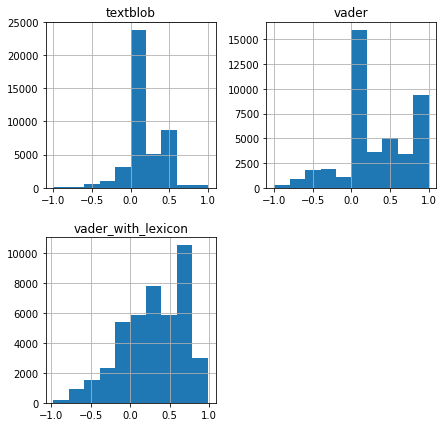

In [119]:
# Frequency distributions of each sentiment classifier
df_t.hist();

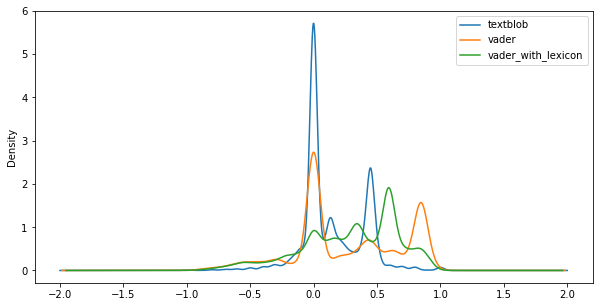

In [120]:
df_t.plot.kde(figsize=(10,5));

### Combined

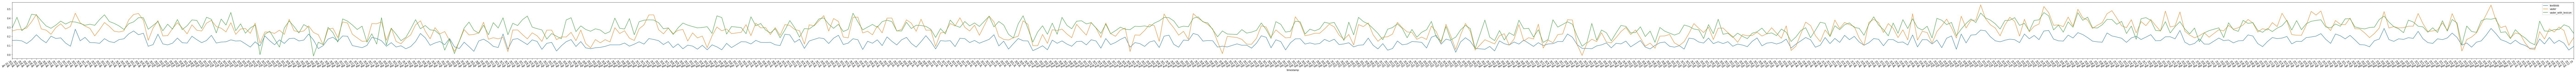

In [121]:
# Get more granularity with dates

#plot data
df_t.index = pd.to_datetime(df_t.index)
fig, ax = plt.subplots(figsize=(200,5))
df_t.groupby(df_t.index).mean().plot(ax=ax)

#set ticks every week
ax.xaxis.set_major_locator(mdates.DayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %y'))

January 29, 2019: first quarter press release was positive

April 30, 2019: second quarter press release was positive




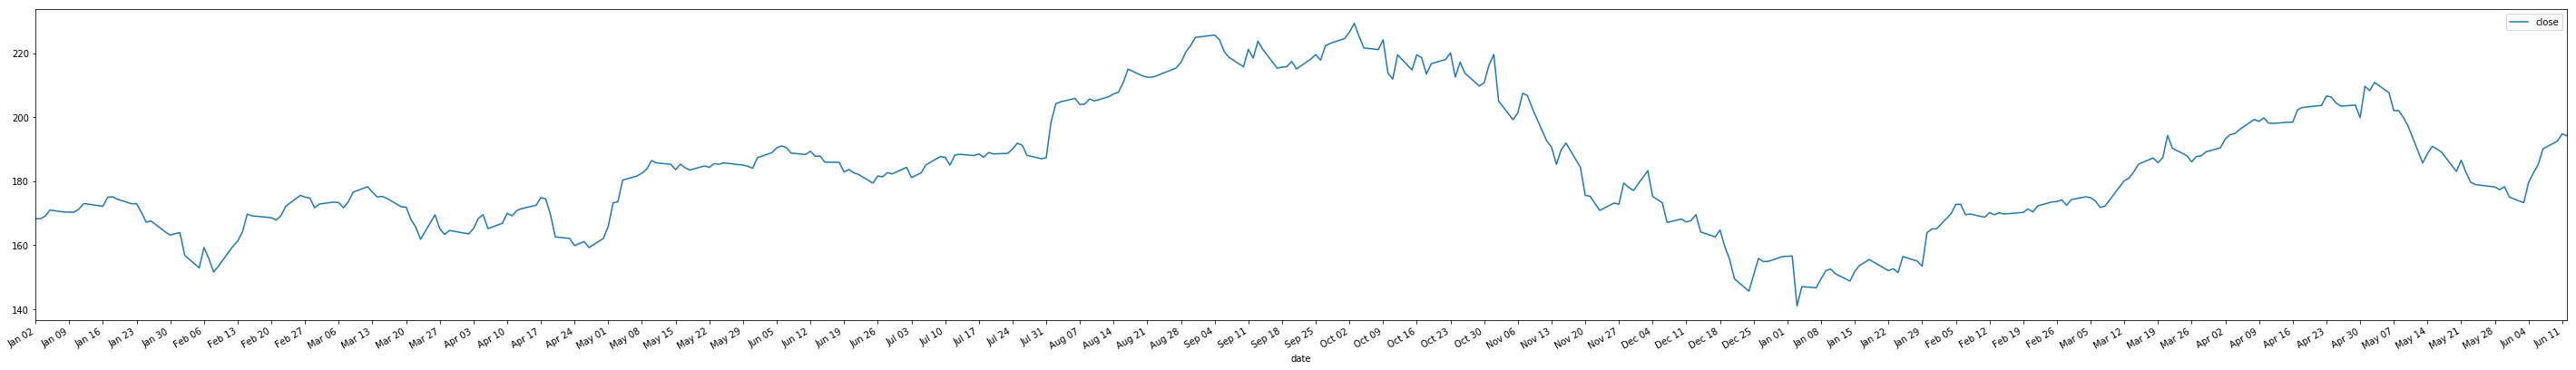

In [158]:
1# Get stock data for Apple for corresponding sentiment dates
start = df_t.index[0].date()
end = df_t.index[-1].date()

# Load price data
s = web.DataReader('AAPL','iex',start=start,end=end)
s.index = pd.to_datetime(s.index)
#plot data
fig, ax = plt.subplots(figsize=(50,7))
s[['close']].plot(ax=ax)
# #set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
# #set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [176]:
df_j = s.join(df_t)
df_j.isna().sum(), df_j.shape

(open                  0
 high                  0
 low                   0
 close                 0
 volume                0
 text                  3
 textblob              3
 vader                 3
 vader_with_lexicon    3
 dtype: int64, (29812, 9))

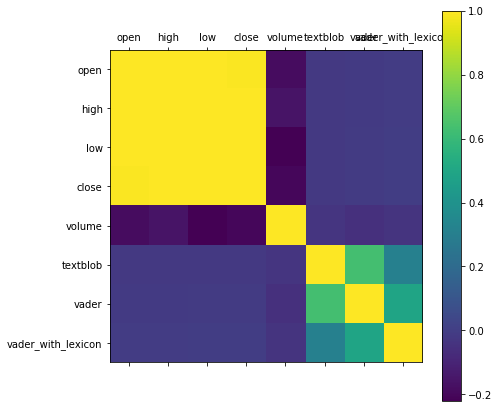

In [177]:
from pylab import rcParams
rcParams['figure.figsize'] = (7, 7)
corr = df_j.corr()
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

In [178]:
df_j.head()

,open,high,low,close,volume,text,textblob,vader,vader_with_lexicon
2018-01-02,166.2868,168.3781,165.4073,168.339,25555934,ICYMI It 's A New Year And Everyone 's Polishi...,0.136364,0.1779,0.4833
2018-01-02,166.2868,168.3781,165.4073,168.339,25555934,Up Moves +3.7 XME +3.5 FXI +3 EWZ +2.8 XBI +2....,0.000000,0.0000,-0.0075
2018-01-02,166.2868,168.3781,165.4073,168.339,25555934,aapl mck googl hpq hpe,0.000000,0.0000,0.0000
2018-01-02,166.2868,168.3781,165.4073,168.339,25555934,AAPL TGT ICYMI It ’ A New Year And Everyone ’ ...,0.136364,0.0000,0.3121
2018-01-02,166.2868,168.3781,165.4073,168.339,25555934,Some *best performing TODAY /2 AAPL AAV AG AIN...,0.700000,0.7324,0.8903


In [179]:
# Group the by date so there is only 1 row per day
df_j = df_j.groupby(df_j.index).mean()
df_j['Daily Pct. Change'] = (df_j.close - df_j.open) / df_j.open
df_j.head()

,open,high,low,close,volume,textblob,vader,vader_with_lexicon,Daily Pct. Change
2018-01-02,166.2868,168.3781,165.4073,168.3390,25555934,0.158236,0.274814,0.409955,0.012341
2018-01-03,168.6028,170.5768,168.0458,168.3096,29517899,0.151545,0.273865,0.263139,-0.001739
2018-01-04,168.6126,169.5214,168.1631,169.0914,22434597,0.122386,0.292951,0.311394,0.002840
2018-01-05,169.4921,171.3782,169.1110,171.0166,23660018,0.162005,0.359969,0.442621,0.008995
2018-01-08,170.3814,171.6127,169.9710,170.3814,20567766,0.130950,0.269576,0.314996,0.000000


In [0]:
# Scale the data
df_scaledT = pd.DataFrame(MinMaxScaler().fit_transform(df_j), 
                          columns=df_j.columns)
df_scaledT.fillna(df_scaledT.mean(), inplace=True)

In [181]:
df_scaledT.shape

(363, 9)

In [182]:
# Split into training and testing sets predicting closing price
# using sentiment classifiers only

X = df_scaledT[['vader','vader_with_lexicon','textblob']]
y = df_scaledT['Daily Pct. Change']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=.5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((181, 3), (182, 3), (181,), (182,))

In [183]:
%%time

tpot = TPOTRegressor(generations=10, verbosity=2, n_jobs=-1, cv=2)
tpot.fit(X_train, y_train)
y_predT = tpot.predict(X_test)
mse = mean_squared_error(y_test, y_predT)
print('TPOT Regression Model MSE:',mse)
print('r2 score', r2_score(y_test, y_predT))

[19:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[19:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


### Vader

In [175]:
%%time

X = df_scaledT[['vader']]
y = df_scaledT['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

tpot = TPOTRegressor(generations=10, verbosity=2, n_jobs=-1, cv=2)
tpot.fit(X_train, y_train)
y_predT = tpot.predict(X_test)
mse = mean_squared_error(y_test, y_predT)
print('TPOT Regression Model MSE:',mse)
print('r2 score', r2_score(y_test, y_predT))

[19:33:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:33:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[19:34:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:34:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### Vader with financial lexicon

In [70]:
X = df_scaledT[['vader_with_lexicon']]
y = df_scaledT['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

tpot = TPOTRegressor(generations=3, verbosity=2, n_jobs=-1, cv=2)
tpot.fit(X_train, y_train)
y_predT = tpot.predict(X_test)
mse = mean_squared_error(y_test, y_predT)
print('TPOT Regression Model MSE:',mse)
print('r2 score', r2_score(y_test, y_predT))

[13:57:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:57:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[13:59:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### Textblob

In [71]:
X = df_scaled[['textblob']]
y = df_scaled['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

tpot = TPOTRegressor(generations=3, population_size=50,
                     verbosity=2, n_jobs=-1, cv=2)
tpot.fit(X_train, y_train)
y_predT = tpot.predict(X_test)
mse = mean_squared_error(y_test, y_predT)
print('TPOT Regression Model MSE:',mse)
print('r2 score', r2_score(y_test, y_predT))

[14:10:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[14:10:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

# 2. Reddit Sentiment Model

### Data gathering and preprocessing

In [25]:
import time
import datetime
d = datetime.date(2019,6,12)

time.mktime(d.timetuple())

1560297600.0

In [0]:
import requests
import json
from datetime import datetime


#####################
# Reddit API Scraping
#####################

def convert_unix_to_datetime(ts):
    return datetime.utcfromtimestamp(int(ts)).strftime("%Y-%m-%d %H:%M:%S")

def get_push_shift_data(query, after, before, sub):
    """
        Gets comments for a given keyword between two dates for a single subreddit
        up to a limit of 1000

        Args:
            - query: keyword to search for
            - after: start search date as a unix timestamp
            - before: end search date as a unix timestamp
            - sub: subreddit to search

        Returns:
            - json response of search query
    """
    url = (
            "https://api.pushshift.io/reddit/search/comment/?q="
            + str(query)
            + "&size=1000&after="
            + str(after)
            + "&before="
            + str(before)
            + "&subreddit="
            + str(sub)
    )
    r = requests.get(url)
    data = json.loads(r.text)
    return data["data"]


def timestamp_to_date(ts):
    return datetime.utcfromtimestamp(ts).date()


def collect_sub_data(submission):
    """
    Parses a reddit submission for text and timestamp

    Args:
        - submission: json formatted reddit submission

    Returns:
        - tuple: (comment_text, timestamp)
    """
    try:
        return submission["body"], timestamp_to_date(submission["created_utc"])
    except KeyError:
        return "", timestamp_to_date(submission["created_utc"])


def get_all_push_shift_data(
        query,
        after="1514764800",
        before="1560297600",
        subs=["stocks", "wallstreetbets", "Trading", "investing"],
):
    """
    Gets comments for a given keyword between two dates

    Args:
        - query: keyword to search for
        - after: start search date as a unix timestamp
        - before: end search date as a unix timestamp
        - subs: list of subreddits to search

    Returns:
        - list of tuples containing (comment_text, comment_timestamp)
    """

    print("Gathering data for ticker " + query)
    print("Starting date:", convert_unix_to_datetime(after))
    print("Ending date:", convert_unix_to_datetime(before))

    comments = []

    for sub in subs:
        data = get_push_shift_data(query, after, before, sub)
        # Will run until all posts have been gathered
        # from the 'after' date up until before date
        while len(data) > 0:
            for submission in data:
                comments.append(collect_sub_data(submission))

            after_iter = data[-1]["created_utc"]
            data = get_push_shift_data(query, after_iter, before, sub)

        print(sub)
        print(len(comments))

    return comments

In [27]:
reddit_data = get_all_push_shift_data('AAPL')

Gathering data for ticker AAPL
Starting date: 2018-01-01 00:00:00
Ending date: 2019-06-12 00:00:00
stocks
2210
wallstreetbets
20353
Trading
20357
investing
22988


In [184]:
len(reddit_data)

22988

In [185]:
df_r = pd.DataFrame(index=[i[1] for i in reddit_data], 
                    data=[i[0] for i in reddit_data], columns=['reddit_posts'])
df_r.shape

(22988, 1)

In [186]:
df_r.head()

,reddit_posts
2018-01-02,Wow this is so painful to look at I just have ...
2018-01-02,"This has been discussed to death, but they hav..."
2018-01-02,$TCHEY\n$V\n$ABBV\n$NVDA\n$AAPL
2018-01-02,Market Cap of TGT is only $35B. I would have ...
2018-01-02,And market reacts on that. Kinda homo if you a...


In [187]:
df_r.sample(10)

,reddit_posts
2018-12-12,What got me into it was I worked at Apple a wh...
2019-04-09,Tim AAPL don't kill me daddy
2018-10-23,AAPL stronk\nAAPL chad\n
2019-04-25,Unfortunately Im on the black out list for aapl 😔
2018-12-17,AAPL. Because it's Apple. Forward PE of 11. Cr...
2018-10-09,C'mon AAPL. You gotta have some more momentum ...
2019-01-14,wow tech really does drive this market.\n\nlow...
2018-01-29,I have AAPL calls that I bought on Friday. My ...
2018-11-19,SOME HIGH ROLLER BETTE FUCKING READ THAT PEOPL...
2018-11-05,How long will I have to fiddle my thumbs for? ...


In [191]:
%%time
# Get sentiment for all classifiers

# Textblob
from textblob import TextBlob
df_r['textblob'] = [TextBlob(t).sentiment.polarity \
                    for t in df_r['reddit_posts']]

# Vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader1 = SentimentIntensityAnalyzer()
df_r['vader'] = [vader1.polarity_scores(t)['compound'] \
                 for t in df_r['reddit_posts']]

# Vader with financial lexicon
ANALYZER = SentimentIntensityAnalyzer()

def stock_market_lexicon():
    stock_lexicon = pd.read_csv(
        'https://raw.githubusercontent.com/jasonyip184/StockSentimentTrading/\
master/lexicon_data/stock_lex.csv')
    stock_lexicon['sentiment'] = (stock_lexicon['Aff_Score'] + \
                                  stock_lexicon['Neg_Score']) / 2
    stock_lexicon = dict(zip(stock_lexicon.Item, stock_lexicon.sentiment))
    stock_lexicon = {k: v for k, v in stock_lexicon.items() \
                     if len(k.split(' ')) == 1}
    stock_lexicon_scaled = {}
    for k, v in stock_lexicon.items():
        if v > 0:
            stock_lexicon_scaled[k] = v / max(stock_lexicon.values()) * 4
        else:
            stock_lexicon_scaled[k] = v / min(stock_lexicon.values()) * -4

    return stock_lexicon

ANALYZER.lexicon.update(stock_market_lexicon())
df_r['vader_with_lexicon'] = [ANALYZER.polarity_scores(t)['compound'] \
                              for t in df_r['reddit_posts']]

CPU times: user 41.5 s, sys: 60.1 ms, total: 41.6 s
Wall time: 41.8 s


In [192]:
df_r.head()

,reddit_posts,textblob,vader,vader_with_lexicon
2018-01-02,Wow this is so painful to look at I just have ...,-0.109722,0.9434,0.9526
2018-01-02,"This has been discussed to death, but they hav...",0.246591,0.8188,0.6919
2018-01-02,$TCHEY\n$V\n$ABBV\n$NVDA\n$AAPL,0.000000,0.0000,0.0000
2018-01-02,Market Cap of TGT is only $35B. I would have ...,0.190476,0.9313,0.9206
2018-01-02,And market reacts on that. Kinda homo if you a...,0.125000,0.2732,0.7945


### Combined

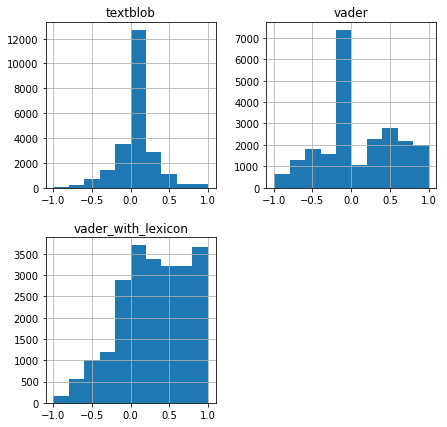

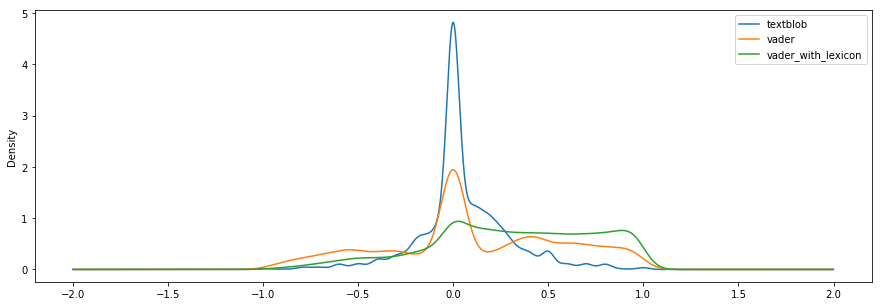

In [128]:
# Frequency distributions of each sentiment classifier

df_r.hist(), df_r.plot.kde(figsize=(15,5));

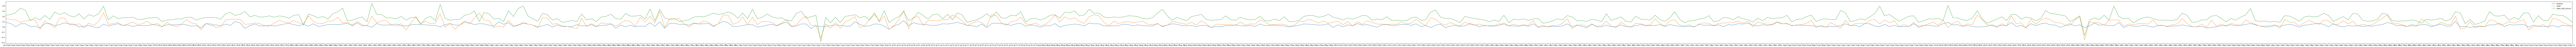

In [129]:
# See with granular dates

# plot data
fig, ax = plt.subplots(figsize=(300,5))
df_r.groupby(df_r.index).mean().plot(ax=ax)

# set ticks every week
ax.xaxis.set_major_locator(mdates.DayLocator())
# set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [150]:
[i[1] for i in reddit_data][0]

datetime.date(2018, 1, 2)

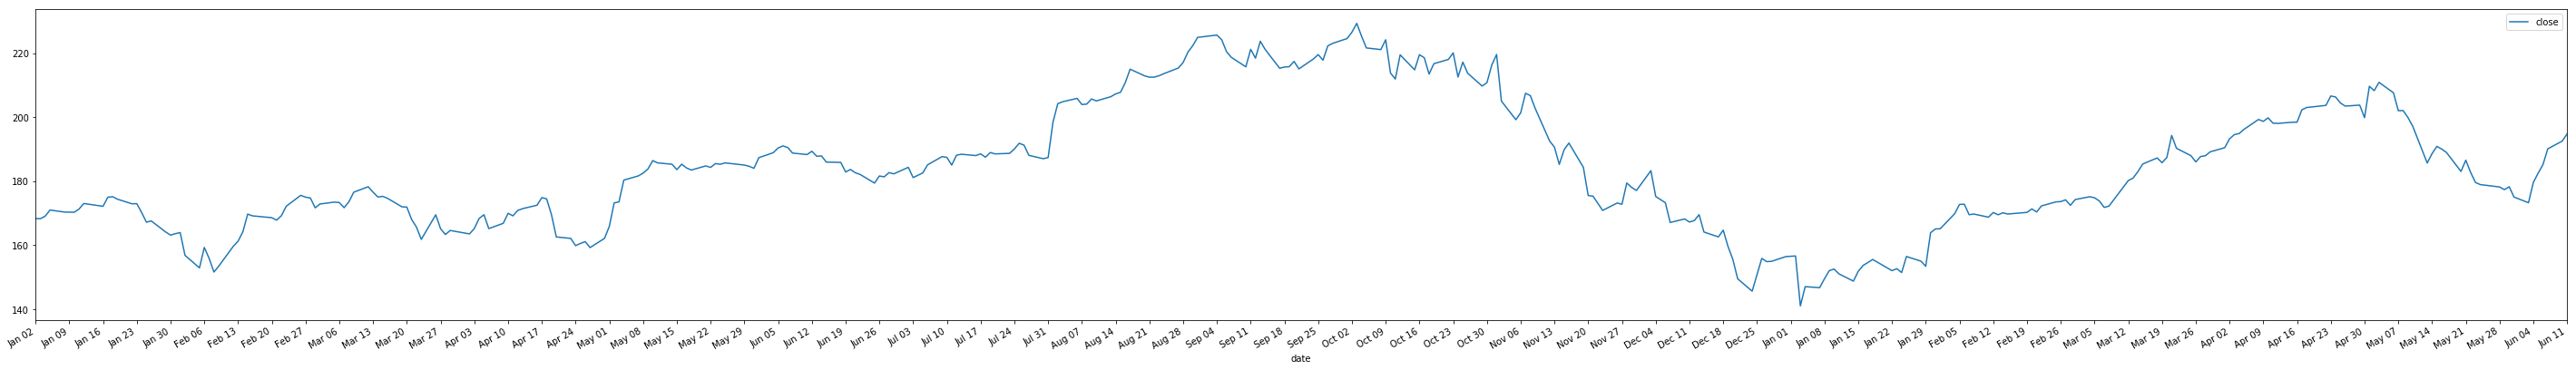

In [130]:
start = [i[1] for i in reddit_data][0] # date of first reddit post
end = [i[1] for i in reddit_data][-1] # date of last reddit post

# Load price data
s = web.DataReader('AAPL','iex',start=start,end=end)
s.index = pd.to_datetime(s.index)
#plot data
fig, ax = plt.subplots(figsize=(50,7))
s[['close']].plot(ax=ax)
# #set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
# #set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

In [195]:
# Join stock data with sentiment data
df_j = s.join(df_r)

# Group the by date so there is only 1 row per day
df_j = df_j.groupby(df_j.index).mean()
df_j['Daily Pct. Change'] = (df_j.close - df_j.open) / df_j.open
df_j.fillna(df_j.mean(), inplace=True)
display(df_j.shape, df_j.head())

(363, 9)

,open,high,low,close,volume,textblob,vader,vader_with_lexicon,Daily Pct. Change
2018-01-02,166.2868,168.3781,165.4073,168.3390,25555934,0.128051,0.286083,0.471803,0.012341
2018-01-03,168.6028,170.5768,168.0458,168.3096,29517899,0.007517,0.263568,0.546718,-0.001739
2018-01-04,168.6126,169.5214,168.1631,169.0914,22434597,0.119691,0.174008,0.719838,0.002840
2018-01-05,169.4921,171.3782,169.1110,171.0166,23660018,0.120639,0.226835,0.632135,0.008995
2018-01-08,170.3814,171.6127,169.9710,170.3814,20567766,-0.036127,-0.086340,0.265587,0.000000


In [196]:
df_j.isna().sum()

open                  0
high                  0
low                   0
close                 0
volume                0
textblob              0
vader                 0
vader_with_lexicon    0
Daily Pct. Change     0
dtype: int64

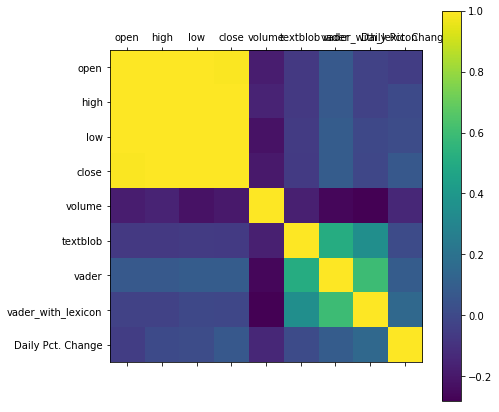

In [197]:
from pylab import rcParams
rcParams['figure.figsize'] = (7, 7)
corr = df_j.corr()
plt.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

In [198]:
df_j.head()

,open,high,low,close,volume,textblob,vader,vader_with_lexicon,Daily Pct. Change
2018-01-02,166.2868,168.3781,165.4073,168.3390,25555934,0.128051,0.286083,0.471803,0.012341
2018-01-03,168.6028,170.5768,168.0458,168.3096,29517899,0.007517,0.263568,0.546718,-0.001739
2018-01-04,168.6126,169.5214,168.1631,169.0914,22434597,0.119691,0.174008,0.719838,0.002840
2018-01-05,169.4921,171.3782,169.1110,171.0166,23660018,0.120639,0.226835,0.632135,0.008995
2018-01-08,170.3814,171.6127,169.9710,170.3814,20567766,-0.036127,-0.086340,0.265587,0.000000


In [0]:
# Scale the data
# cols = ['close','textblob','vader','vader_with_lexicon']
# df_scaledR = pd.DataFrame(MinMaxScaler().fit_transform(df_j[cols]),columns=cols)

df_scaledR = pd.DataFrame(MinMaxScaler().fit_transform(df_j), 
                          columns=df_j.columns)

In [202]:
df_scaledR.head()

,open,high,low,close,volume,textblob,vader,vader_with_lexicon,Daily Pct. Change
0,0.275161,0.276421,0.284619,0.308983,0.155698,0.732971,0.553196,0.538035,0.526123
1,0.302311,0.301917,0.315201,0.308650,0.203018,0.264677,0.519881,0.644905,0.385563
2,0.302426,0.289679,0.316560,0.317499,0.118418,0.700493,0.387360,0.891870,0.431270
3,0.312737,0.311210,0.327547,0.339289,0.133054,0.704175,0.465528,0.766757,0.492713
4,0.323162,0.313930,0.337515,0.332100,0.096122,0.095112,0.002127,0.243856,0.402923


In [210]:
# Split into training and testing sets predicting closing price
# with all sentiment classifiers

X = df_scaledR[['vader','vader_with_lexicon','textblob']]
y = df_scaledR['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                   test_size=0.5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((181, 3), (182, 3), (181,), (182,))

In [211]:
%%time

tpot = TPOTRegressor(generations=10, verbosity=2, n_jobs=-1, cv=2)
tpot.fit(X_train, y_train)
y_predT = tpot.predict(X_test)
mse = mean_squared_error(y_test, y_predT)
print('TPOT Regression Model MSE:',mse)
print('r2 score', r2_score(y_test, y_predT))

[20:04:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[20:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### Vader

In [219]:
X = df_scaledR[['vader']]
y = df_scaledR['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                   test_size=.5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((181, 1), (182, 1), (181,), (182,))

In [220]:
%%time

tpot = TPOTRegressor(generations=10, verbosity=2, n_jobs=-1, cv=2)
tpot.fit(X_train, y_train)
y_predT = tpot.predict(X_test)
mse = mean_squared_error(y_test, y_predT)
print('TPOT Regression Model MSE:',mse)
print('r2 score', r2_score(y_test, y_predT))

[20:18:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:18:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[20:19:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:19:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

### Vader with financial lexicon

In [221]:
X = df_scaledR[['vader_with_lexicon']]
y = df_scaledR['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                   test_size=0.5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((181, 1), (182, 1), (181,), (182,))

In [222]:
%%time

tpot = TPOTRegressor(generations=10, verbosity=2, n_jobs=-1, cv=2)
tpot.fit(X_train, y_train)
y_predT = tpot.predict(X_test)
mse = mean_squared_error(y_test, y_predT)
print('TPOT Regression Model MSE:',mse)
print('r2 score', r2_score(y_test, y_predT))

[20:22:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[20:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [68]:
X.columns

Index(['vader_with_lexicon'], dtype='object')

In [85]:
df_scaled.var()

close                 0.064646
textblob              0.014619
vader                 0.054349
vader_with_lexicon    0.047683
dtype: float64

In [90]:
from scipy.stats import ttest_ind

ttest_ind(df_scaled['textblob'], df_scaled['close'], equal_var=False)[1]

0.04511754379041569

### Textblob

In [223]:
X = df_scaledR[['textblob']]
y = df_scaledR['close']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                   test_size=0.5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((181, 1), (182, 1), (181,), (182,))

In [224]:
%%time

tpot = TPOTRegressor(generations=10, verbosity=2, n_jobs=-1, cv=2)
tpot.fit(X_train, y_train)
y_predT = tpot.predict(X_test)
mse = mean_squared_error(y_test, y_predT)
print('TPOT Regression Model MSE:',mse)
print('r2 score', r2_score(y_test, y_predT))

[20:25:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[20:25:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:25:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

# Conclusion

In [0]:
# Summary of r2 and MSE

r2_twitter = {'textlob':0.006, 'vader':0.002, 'vader_with_lexicon':0.032, 'combined':0.22}
MSE_twitter = {'textlob':0.05, 'vader':0.05, 'vader_with_lexicon':0.05, 'combined':0.04}
r2_reddit = {'textlob':0.0018, 'vader':0.0006, 'vader_with_lexicon':-0.00017, 'combined':0.003}
MSE_reddit = {'textlob':0.064, 'vader':0.06, 'vader_with_lexicon':0.06, 'combined':0.06}
               
# P-values

from scipy.stats import ttest_ind

textblobPT = ttest_ind(df_scaledT['textblob'], df_scaledT['close'], 
                       equal_var=False)[1]
vaderPT = ttest_ind(df_scaledT['vader'], df_scaledT['close'], 
                    equal_var=False)[1]
vader_with_lexiconPT = ttest_ind(df_scaledT['vader_with_lexicon'], 
                                 df_scaledT['close'], equal_var=False)[1]
combinedPT = np.mean(ttest_ind(df_scaledT[['textblob','vader',
                                  'vader_with_lexicon']].values, 
                       df_scaledT['close'], equal_var=False)[1])

p_twitter = {'textlob':textblobPT, 'vader':vaderPT, 'vader_with_lexicon':vader_with_lexiconPT, 'combined':combinedPT}


textblobPR = ttest_ind(df_scaledR['textblob'], df_scaledR['close'], 
                       equal_var=False)[1]
vaderPR = ttest_ind(df_scaledR['vader'], df_scaledR['close'], 
                       equal_var=False)[1]
vader_with_lexiconPR = ttest_ind(df_scaledR['vader_with_lexicon'], 
                                 df_scaledR['close'], 
                       equal_var=False)[1]
combinedPR = np.mean(ttest_ind(df_scaledR[['textblob','vader',
                                  'vader_with_lexicon']].values, 
                       df_scaledR['close'], equal_var=False)[1])

p_reddit = {'textlob':textblobPR, 'vader':vaderPR, 'vader_with_lexicon':vader_with_lexiconPR, 'combined':combinedPR}

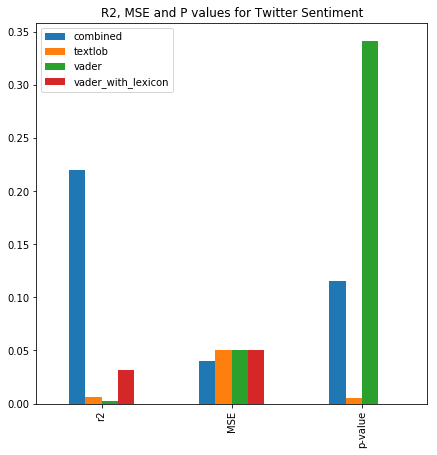

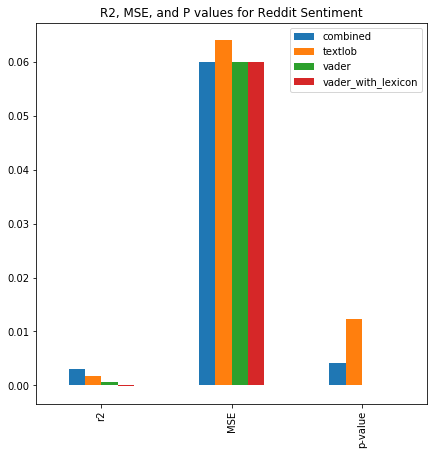

In [256]:
pd.DataFrame([r2_twitter,MSE_twitter, p_twitter], index=['r2','MSE','p-value'])\
              .plot.bar(title='R2, MSE and P values for Twitter Sentiment')

pd.DataFrame([r2_reddit, MSE_reddit, p_reddit], index=['r2','MSE','p-value'])\
              .plot.bar(title='R2, MSE, and P values for Reddit Sentiment')

In [226]:
df_scaledR.var()

open                  0.054351
high                  0.053779
low                   0.052668
close                 0.050855
volume                0.027086
textblob              0.028070
vader                 0.023632
vader_with_lexicon    0.022888
Daily Pct. Change     0.017397
dtype: float64

In [227]:
df_scaledT.var()

open                  0.054351
high                  0.053779
low                   0.052668
close                 0.050855
volume                0.027086
textblob              0.032388
vader                 0.027760
vader_with_lexicon    0.023955
Daily Pct. Change     0.017397
dtype: float64